This Notebook demonstrates comparing different levels of compression on several test variables in the CESM-LENS1 dataset (http://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html). In doing so, we will start a DASK client from Jupyter. 

### Setup

Before using this notebook, we recommend familiarity with the TutorialNotebook and the LargeDataGladeNotebook. This notebook is meant to be run on NCAR's JupyterHub (https://jupyterhub.ucar.edu). The subset of CESM-LENS1 data on glade is located in /glade/p/cisl/asap/abaker/compression_samples/cam-lens.

When you launch your NCAR JupyterHub session, you will need to indicate a
machine (Cheyenne or Casper) and then you will need your charge account. You can
then launch the session and navigate to this notebook.

NCAR's JupyterHub documentation:<br>
https://www2.cisl.ucar.edu/resources/jupyterhub-ncar

**You need to run your notebook with the "cmip6-201910" kernel (choose from the
dropdown in the upper left.)**


When you launch your NCAR JupyterHub session, you will need to indicate a
machine (Cheyenne or Casper) and then you will need your charge account. You can
then launch the session and navigate to this notebook.

NCAR's JupyterHub documentation:<br>
https://www2.cisl.ucar.edu/resources/jupyterhub-ncar


In [2]:
# Make sure you are using the cmpi6-2019.10 kernel

# Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys

sys.path.insert(0, '/glade/u/home/abaker/repos/ldcpy')
import ldcpy

# Display output of plots directly in Notebook
%matplotlib inline
# Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

# silence warnings
import warnings

warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'ldcpy'

Start DASK...

In [2]:
# start the dask scheduler

# for Casper
# from dask_jobqueue import SLURMCluster
# cluster = SLURMCluster(memory="40GB", cores=4, processes=1, walltime="02:00:00", project="NIOW0001")

# for Cheyenne
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    queue="regular",
    walltime="02:00:00",
    project="NIOW0001",
    memory="109GB",
    resource_spec="select=1:ncpus=9:mem=109GB",
    cores=36,
    processes=9,
)


# scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=30)
cluster

Connect to the client...

In [3]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

<Client: 'tcp://10.148.11.122:44459' processes=0 threads=0, memory=0 B>

### Sample Data

In the glade directory mentionned above (/glade/p/cisl/asap/abaker/compression_samples/cam-lens), we have an "orig" directory with the original (uncompressed) version of each sample variable: Q, FLNS, TREFHT, TMQ, PS, U, PRECT, LHFLX, CCN3, TS, and CLOUD.  Then there is a directory for each sample variable with a variety of compressed varients.

Note that each test variables has a two timeseries slices: 1920-2005 and 2006-2080. The range of data is indicated in the filename along with whether the data is "daily" or "monthly" timeslices.

Variables U, CLOUD, and Qare 3D, and the rest are 2D.



In [4]:
# list  directory contents
import os

os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens")

['README.txt',
 'Q',
 'FLNS',
 'TREFHT',
 'TMQ',
 'PS',
 'U',
 'PRECT',
 'LHFLX',
 'CCN3',
 'orig',
 'CLOUD',
 'TS']

In [5]:
# List the original data files
os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens/orig")

['CLOUD.monthly.200601-208012.nc',
 'LHFLX.daily.20060101-20801231.nc',
 'TREFHT.monthly.192001-200512.nc',
 'U.monthly.192001-200512.nc',
 'PRECT.daily.20060101-20801231.nc',
 'CLOUD.monthly.192001-200512.nc',
 'TMQ.monthly.192001-200512.nc',
 'CCN3.monthly.200601-208012.nc',
 'PS.monthly.192001-200512.nc',
 'CCN3.monthly.192001-200512.nc',
 'PRECT.daily.19200101-20051231.nc',
 'TS.daily.20060101-20801231.nc',
 'PS.monthly.200601-208012.nc',
 'TS.daily.19200101-20051231.nc',
 'Q.monthly.192001-200512.nc',
 'Q.monthly.200601-208012.nc',
 'TMQ.monthly.200601-208012.nc',
 'U.monthly.200601-208012.nc',
 'TREFHT.monthly.200601-208012.nc',
 'FLNS.monthly.192001-200512.nc',
 'FLNS.monthly.200601-208012.nc',
 'LHFLX.daily.19200101-20051231.nc']

In [6]:
# List the compressed data files for TMQ
os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ")

['zfp.p22.TMQ.monthly.192001-200512.nc',
 'zfp.p18.TMQ.monthly.200601-208012.nc',
 'zfp.p22.TMQ.monthly.200601-208012.nc',
 'zfp.p20.TMQ.monthly.192001-200512.nc',
 'zfp.p12.TMQ.monthly.200601-208012.nc',
 'zfp.p8.TMQ.monthly.192001-200512.nc',
 'zfp.p18.TMQ.monthly.192001-200512.nc',
 'zfp.p12.TMQ.monthly.192001-200512.nc',
 'zfp.p8.TMQ.monthly.200601-208012.nc',
 'zfp.p10.TMQ.monthly.192001-200512.nc',
 'fpzip16.TMQ.monthly.200601-208012.nc',
 'zfp.p16.TMQ.monthly.192001-200512.nc',
 'zfp.p20.TMQ.monthly.200601-208012.nc',
 'zfp.p10.TMQ.monthly.200601-208012.nc',
 'zfp.p14.TMQ.monthly.200601-208012.nc',
 'zfp.p16.TMQ.monthly.200601-208012.nc',
 'zfp.p14.TMQ.monthly.192001-200512.nc',
 'fpzip16.TMQ.monthly.192001-200512.nc']

Make a collection with some of the TMQ data to compare. We'll look at the 2006-2080 data. Make sure to use "useful" labels. You can't mix the 2006-2080 and 1920-2005 data in the same collection as they have different numbers of time slices.

The "fpzip" version is from the blind evaluation.  For the "zfp" versions, the p indicates the precision parameter (the higher the number after p, the more accurate).

In [7]:
col_tmq = ldcpy.open_datasets(
    ["TMQ"],
    [
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/orig/TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/fpzip16.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p8.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p10.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p12.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p14.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p16.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p18.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p20.TMQ.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TMQ/zfp.p22.TMQ.monthly.200601-208012.nc",
    ],
    [
        "orig",
        "fpzip16",
        "zfp-p8",
        "zfp-p10",
        "zfp-p12",
        "zfp-p14",
        "zfp-p16",
        "zfp-p18",
        "zfp-p20",
        "zfp-p22",
    ],
    chunks={"time": 700},
)
col_tmq

dataset size in GB 1.99



<xarray.Dataset>
Dimensions:     (collection: 10, lat: 192, lon: 288, time: 900)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 2006-02-01 00:00:00 ... 2081-01-01 00:00:00
  * collection  (collection) <U7 'orig' 'fpzip16' ... 'zfp-p20' 'zfp-p22'
Data variables:
    TMQ         (collection, time, lat, lon) float32 dask.array<chunksize=(1, 700, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.BRCP85C5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys1023
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.031.cam.i.2006-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Tue Nov  3 14:06:43 2020: ncks -L 5 TMQ.monthly.200601-...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

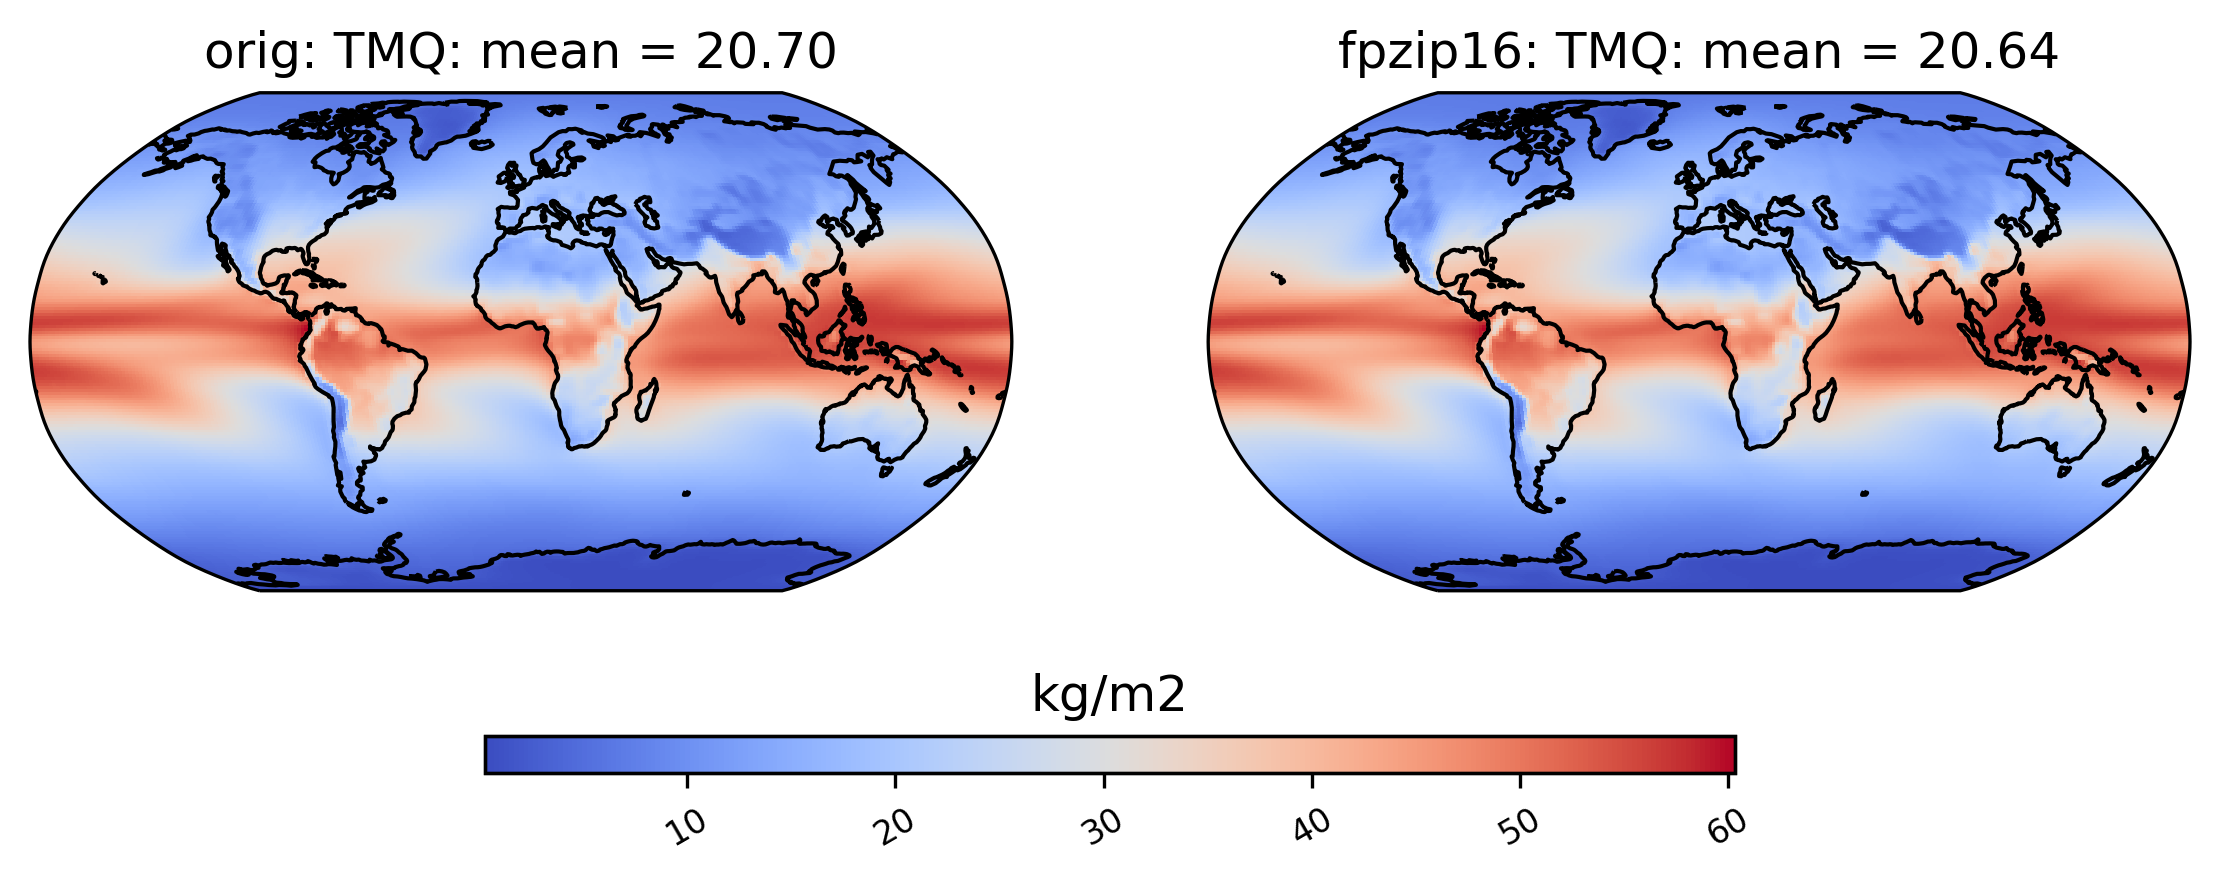

In [8]:
# first compare the mean TMQ values in col_tmq orig and fpzip datasets (which is in the released lens data)
ldcpy.plot(col_tmq, "TMQ", sets=["orig", "fpzip16"], calc="mean")

Let's look at some statistics for the time slice= 100 of the data (the data has 900 time slices)

In [10]:
ldcpy.compare_stats(col_tmq.isel(time=100), "TMQ", "orig", "fpzip16")

 
mean orig                          : 18.83
mean fpzip16                       : 18.777
mean diff                          : 0.052669
 
variance orig                      : 220.84
variance fpzip16                   : 219.64
 
standard deviation orig            : 14.861
standard deviation fpzip16         : 14.82
 
max value orig                     : 56.345
max value fpzip16                  : 56.25
min value orig                     : 0.16246
min value fpzip16                  : 0.16211
 
max abs diff                       : 0.24997
min abs diff                       : 0
mean abs diff                      : 0.052669
mean squared diff                  : 0.002774
root mean squared diff             : 0.077692
normalized root mean squared diff  : 0.0013828
normalized max pointwise error     : 0.0044493
pearson correlation coefficient    : 1
ks p-value                         : 0.0067025
spatial relative error(% > 0.0001) : 98.168
max spatial relative error         : 0.0077457
ssim        

In [12]:
# The compression ratio (CR)for fpzip was ~3.4x better than lossless
# zfp - p10 has a similar CR - look at it's stats
ldcpy.compare_stats(col_tmq.isel(time=100), "TMQ", "orig", "zfp-p10")

 
mean orig                          : 18.83
mean zfp-p10                       : 18.848
mean diff                          : -0.018232
 
variance orig                      : 220.84
variance zfp-p10                   : 221.26
 
standard deviation orig            : 14.861
standard deviation zfp-p10         : 14.875
 
max value orig                     : 56.345
max value zfp-p10                  : 56.5
min value orig                     : 0.16246
min value zfp-p10                  : 0.16162
 
max abs diff                       : 0.53075
min abs diff                       : 2.5332e-07
mean abs diff                      : 0.054665
mean squared diff                  : 0.00033242
root mean squared diff             : 0.08664
normalized root mean squared diff  : 0.0015421
normalized max pointwise error     : 0.0082268
pearson correlation coefficient    : 0.99998
ks p-value                         : 0.13637
spatial relative error(% > 0.0001) : 37.299
max spatial relative error         : 0.03092

In [14]:
# zfp - p12 has a CR of 2.5x, time=100)
ldcpy.compare_stats(col_tmq.isel(time=0), "TMQ", "orig", "zfp-p12")

 
mean orig                          : 17.373
mean zfp-p12                       : 17.377
mean diff                          : -0.0040598
 
variance orig                      : 241.72
variance zfp-p12                   : 241.82
 
standard deviation orig            : 15.547
standard deviation zfp-p12         : 15.551
 
max value orig                     : 59.1
max value zfp-p12                  : 59.109
min value orig                     : 0.43742
min value zfp-p12                  : 0.4375
 
max abs diff                       : 0.14342
min abs diff                       : 0
mean abs diff                      : 0.013363
mean squared diff                  : 1.6482e-05
root mean squared diff             : 0.022262
normalized root mean squared diff  : 0.0003795
normalized max pointwise error     : 0.0020729
pearson correlation coefficient    : 1
ks p-value                         : 0.39259
spatial relative error(% > 0.0001) : 35.408
max spatial relative error         : 0.0053198
ssim      

Let's look at something more interesting...

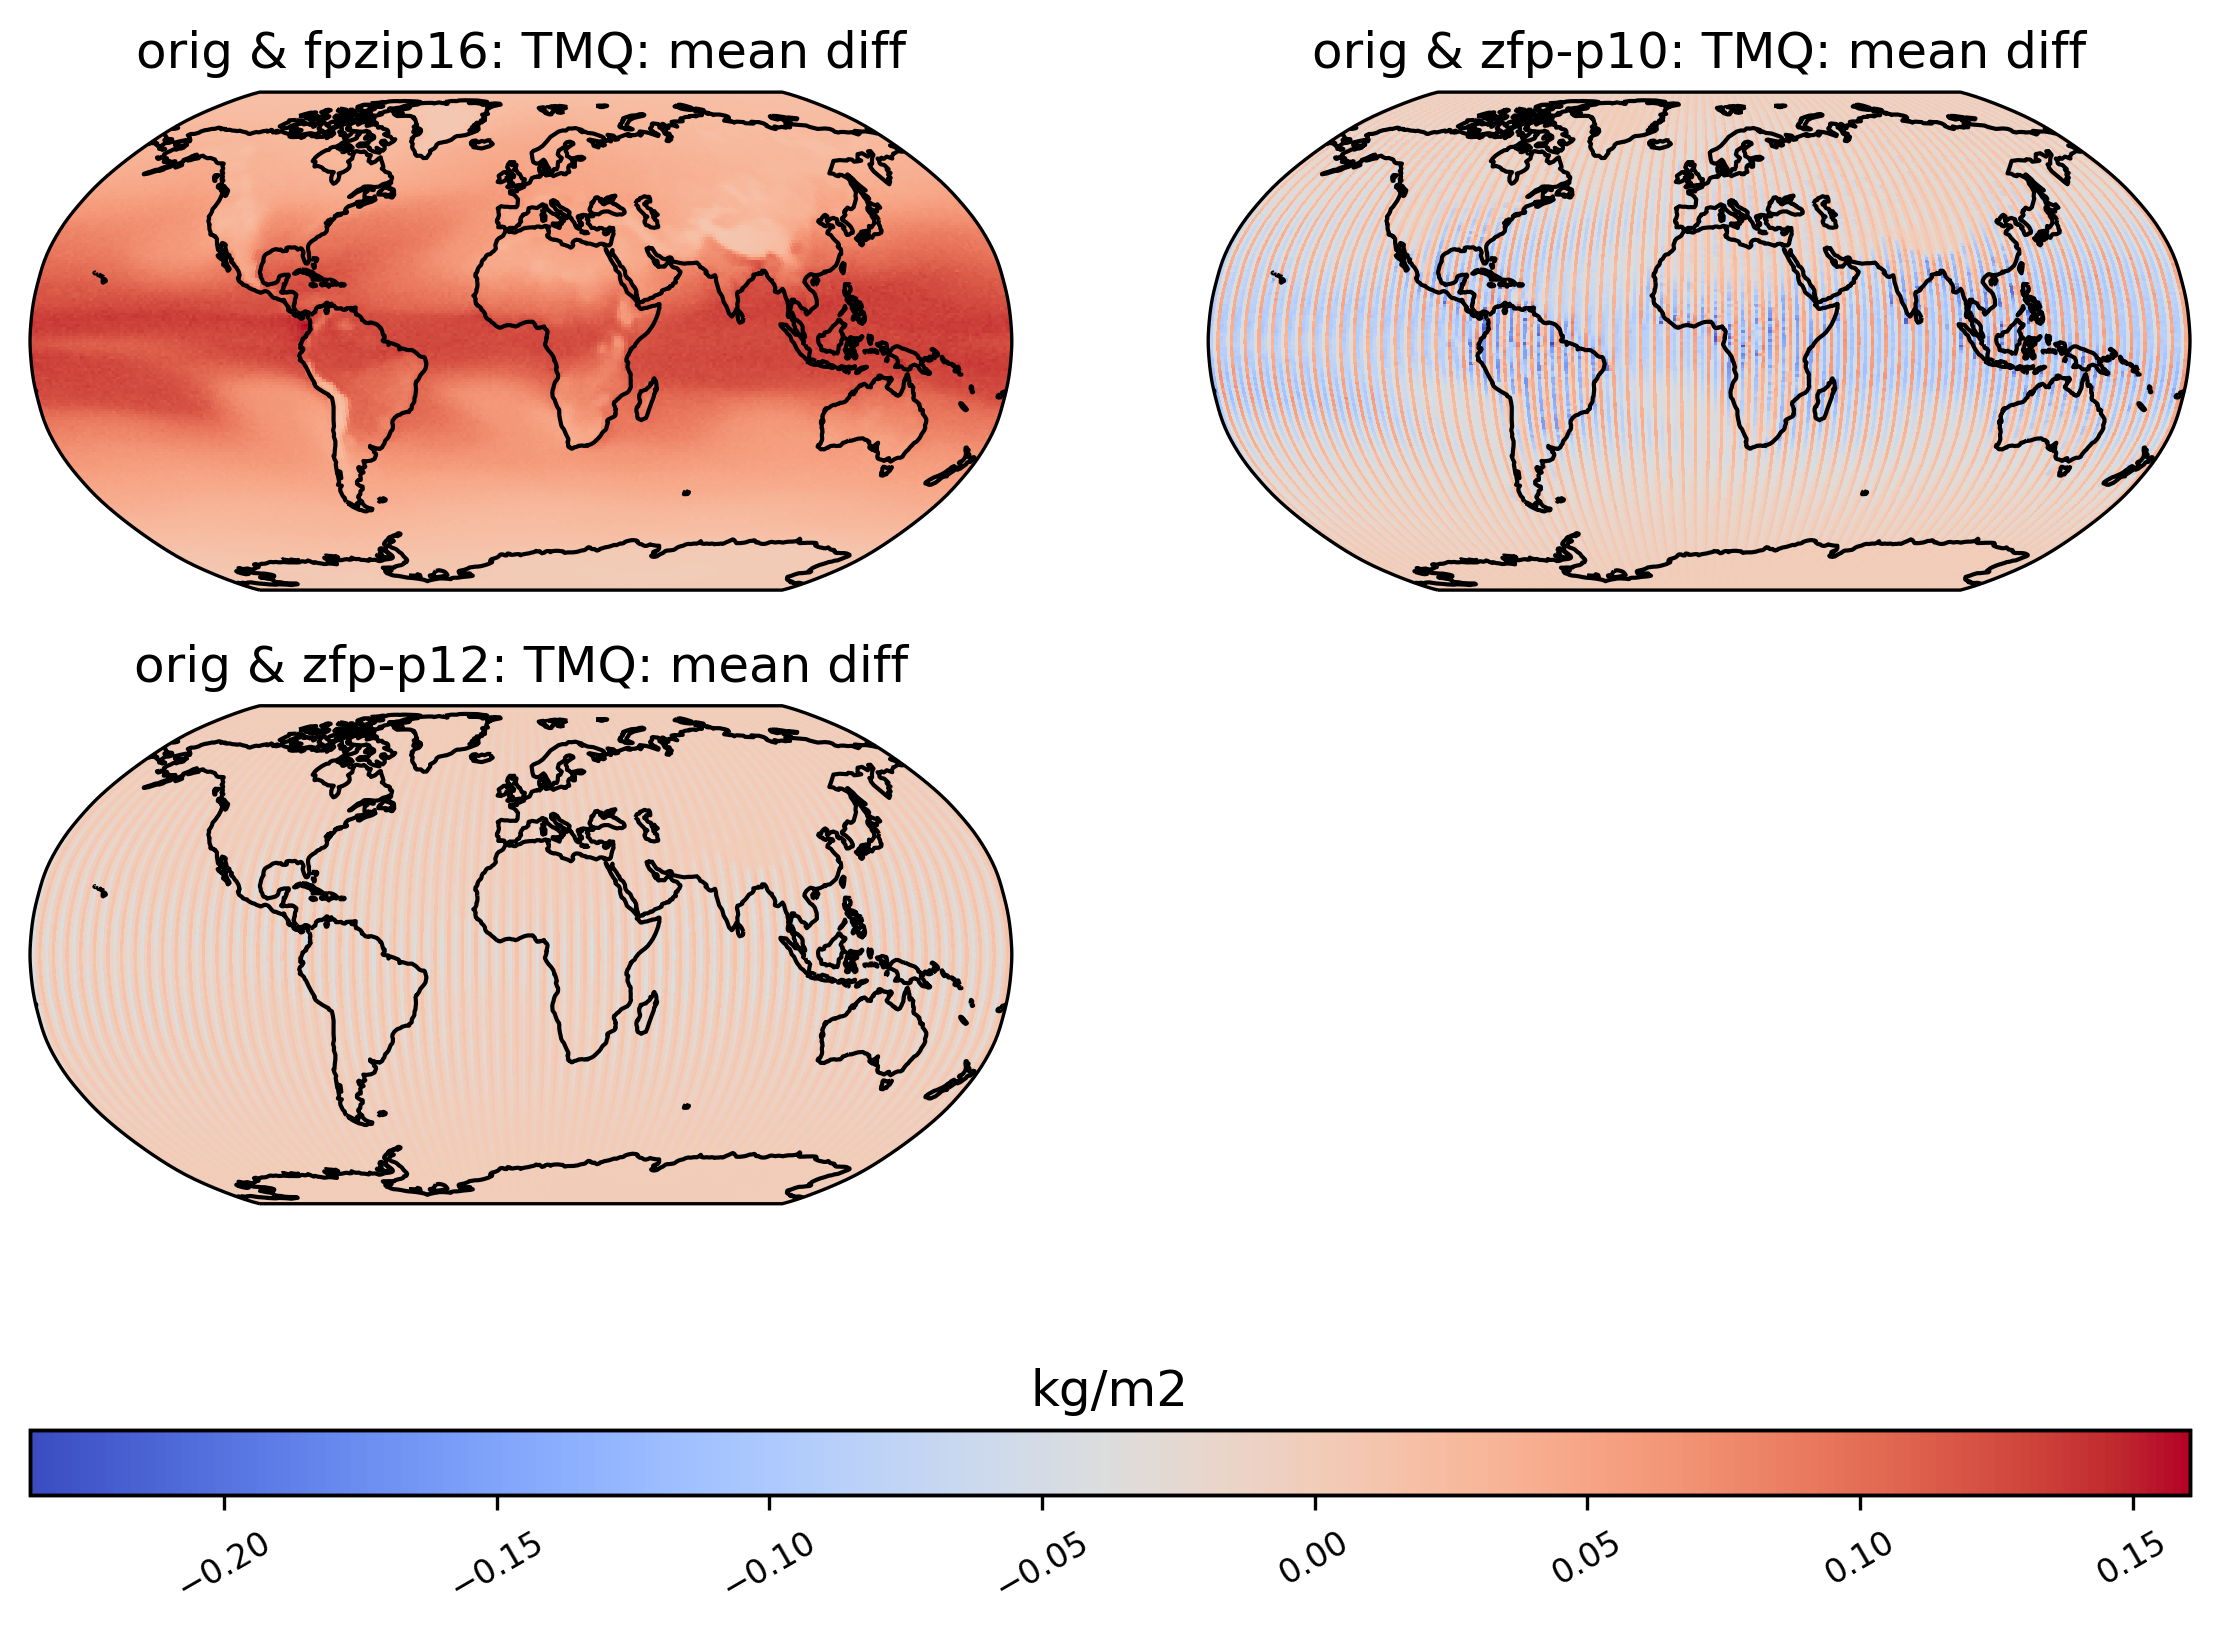

In [15]:
# diff between mean TS values in col_ds "orig" and "zfpA1.0" datasets
ldcpy.plot(
    col_tmq,
    "TMQ",
    sets=["orig", "fpzip16", "zfp-p10", "zfp-p12"],
    calc="mean",
    calc_type="diff",
)

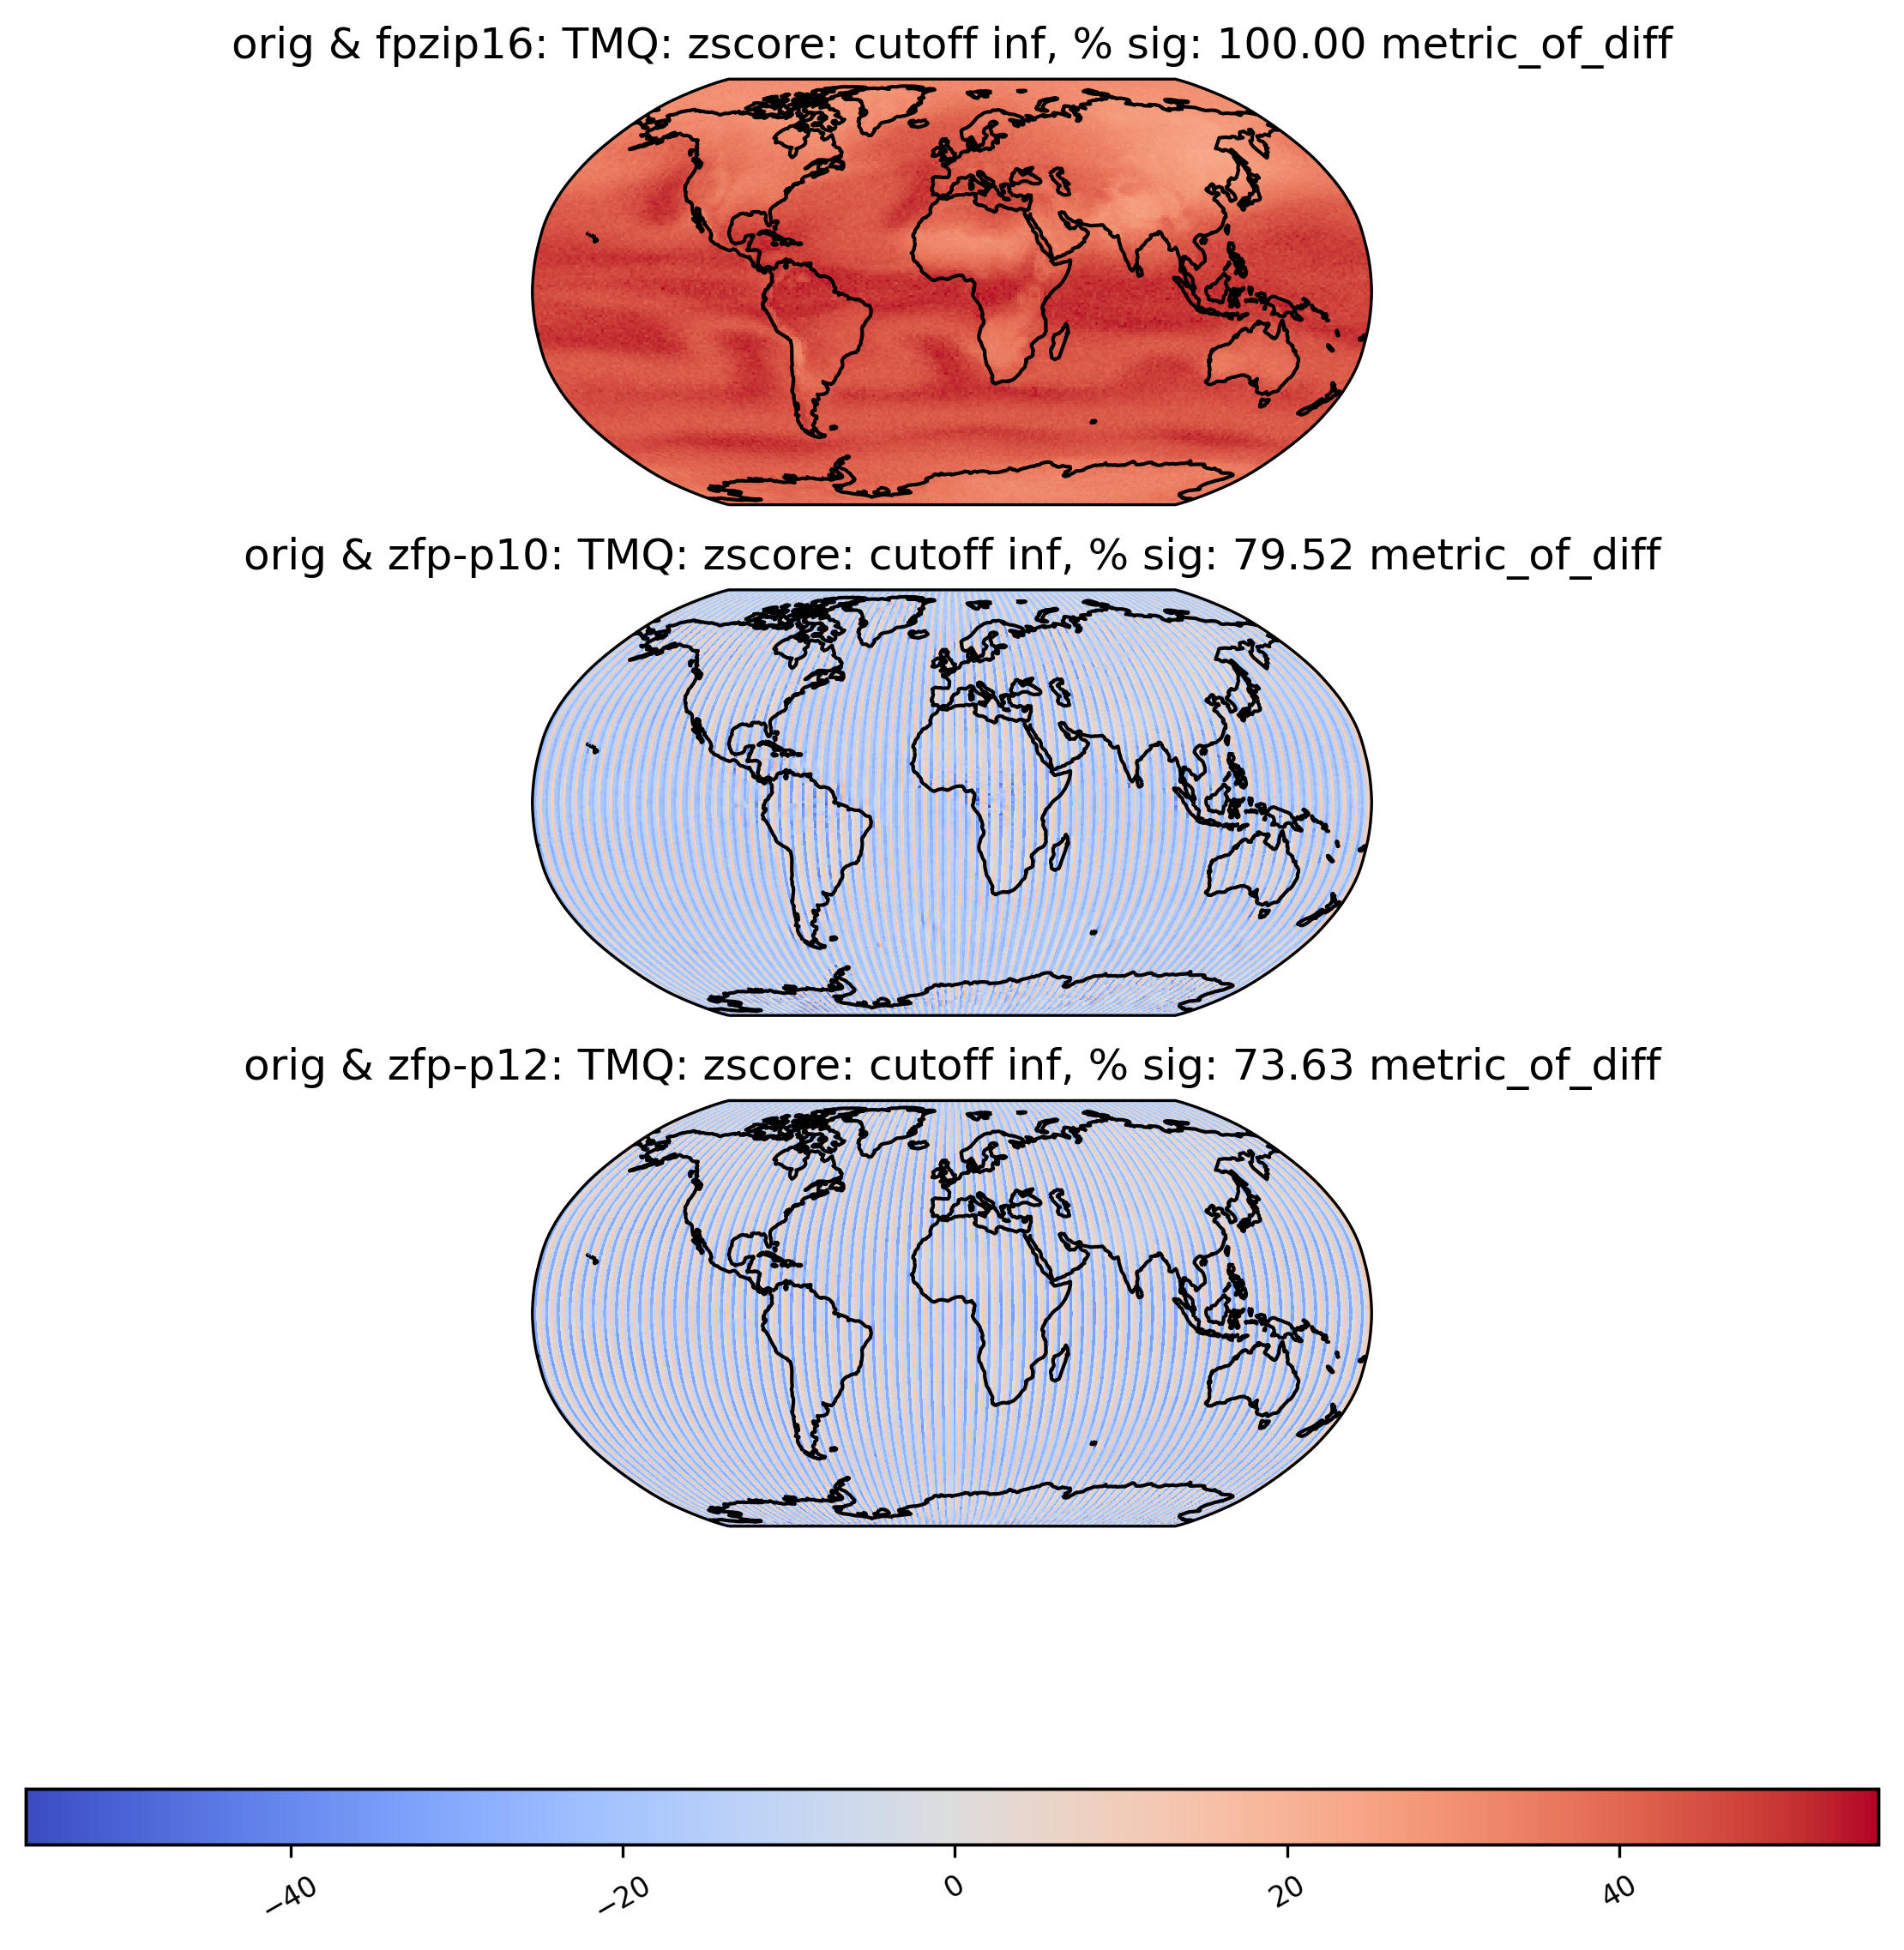

In [16]:
# plot of z-score under null hypothesis that orig value= compressed value
ldcpy.plot(
    col_tmq,
    "TMQ",
    sets=["orig", "fpzip16", "zfp-p10", "zfp-p12"],
    calc="zscore",
    calc_type="calc_of_diff",
)

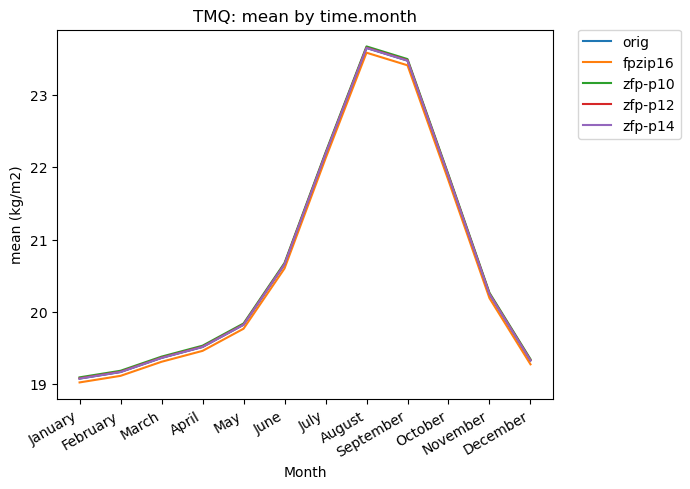

In [17]:
# Time-series plot of TMQ mean in the original and lossy datasets
ldcpy.plot(
    col_tmq,
    "TMQ",
    sets=["orig", "fpzip16", "zfp-p10", "zfp-p12", "zfp-p14"],
    calc="mean",
    plot_type="time_series",
    group_by="time.month",
)

## Now we look at other variables below

In [18]:
# List the compressed data files for TREFHT
os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT")

['zfp.p22.TREFHT.monthly.200601-208012.nc',
 'zfp.p16.TREFHT.monthly.200601-208012.nc',
 'zfp.p14.TREFHT.monthly.200601-208012.nc',
 'zfp.p16.TREFHT.monthly.192001-200512.nc',
 'zfp.p10.TREFHT.monthly.192001-200512.nc',
 'zfp.p14.TREFHT.monthly.192001-200512.nc',
 'zfp.p20.TREFHT.monthly.200601-208012.nc',
 'zfp.p10.TREFHT.monthly.200601-208012.nc',
 'zfp.p18.TREFHT.monthly.192001-200512.nc',
 'zfp.p8.TREFHT.monthly.192001-200512.nc',
 'zfp.p22.TREFHT.monthly.192001-200512.nc',
 'fpzip20.TREFHT.monthly.200601-208012.nc',
 'zfp.p12.TREFHT.monthly.200601-208012.nc',
 'zfp.p20.TREFHT.monthly.192001-200512.nc',
 'zfp.p12.TREFHT.monthly.192001-200512.nc',
 'zfp.p18.TREFHT.monthly.200601-208012.nc',
 'fpzip20.TREFHT.monthly.192001-200512.nc',
 'zfp.p8.TREFHT.monthly.200601-208012.nc']

In [19]:
col_trefht = ldcpy.open_datasets(
    ["TREFHT"],
    [
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/orig/TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/fpzip20.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p8.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p10.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p12.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p14.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p16.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p18.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p20.TREFHT.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/TREFHT/zfp.p22.TREFHT.monthly.200601-208012.nc",
    ],
    [
        "orig",
        "fpzip20",
        "zfp-p8",
        "zfp-p10",
        "zfp-p12",
        "zfp-p14",
        "zfp-p16",
        "zfp-p18",
        "zfp-p20",
        "zfp-p22",
    ],
    chunks={"time": 700},
)
col_trefht

dataset size in GB 1.99



<xarray.Dataset>
Dimensions:     (collection: 10, lat: 192, lon: 288, time: 900)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 2006-02-01 00:00:00 ... 2081-01-01 00:00:00
  * collection  (collection) <U7 'orig' 'fpzip20' ... 'zfp-p20' 'zfp-p22'
Data variables:
    TREFHT      (collection, time, lat, lon) float32 dask.array<chunksize=(1, 700, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.BRCP85C5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys1023
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.031.cam.i.2006-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Tue Nov  3 14:11:24 2020: ncks -L 5 TREFHT.monthly.2006...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

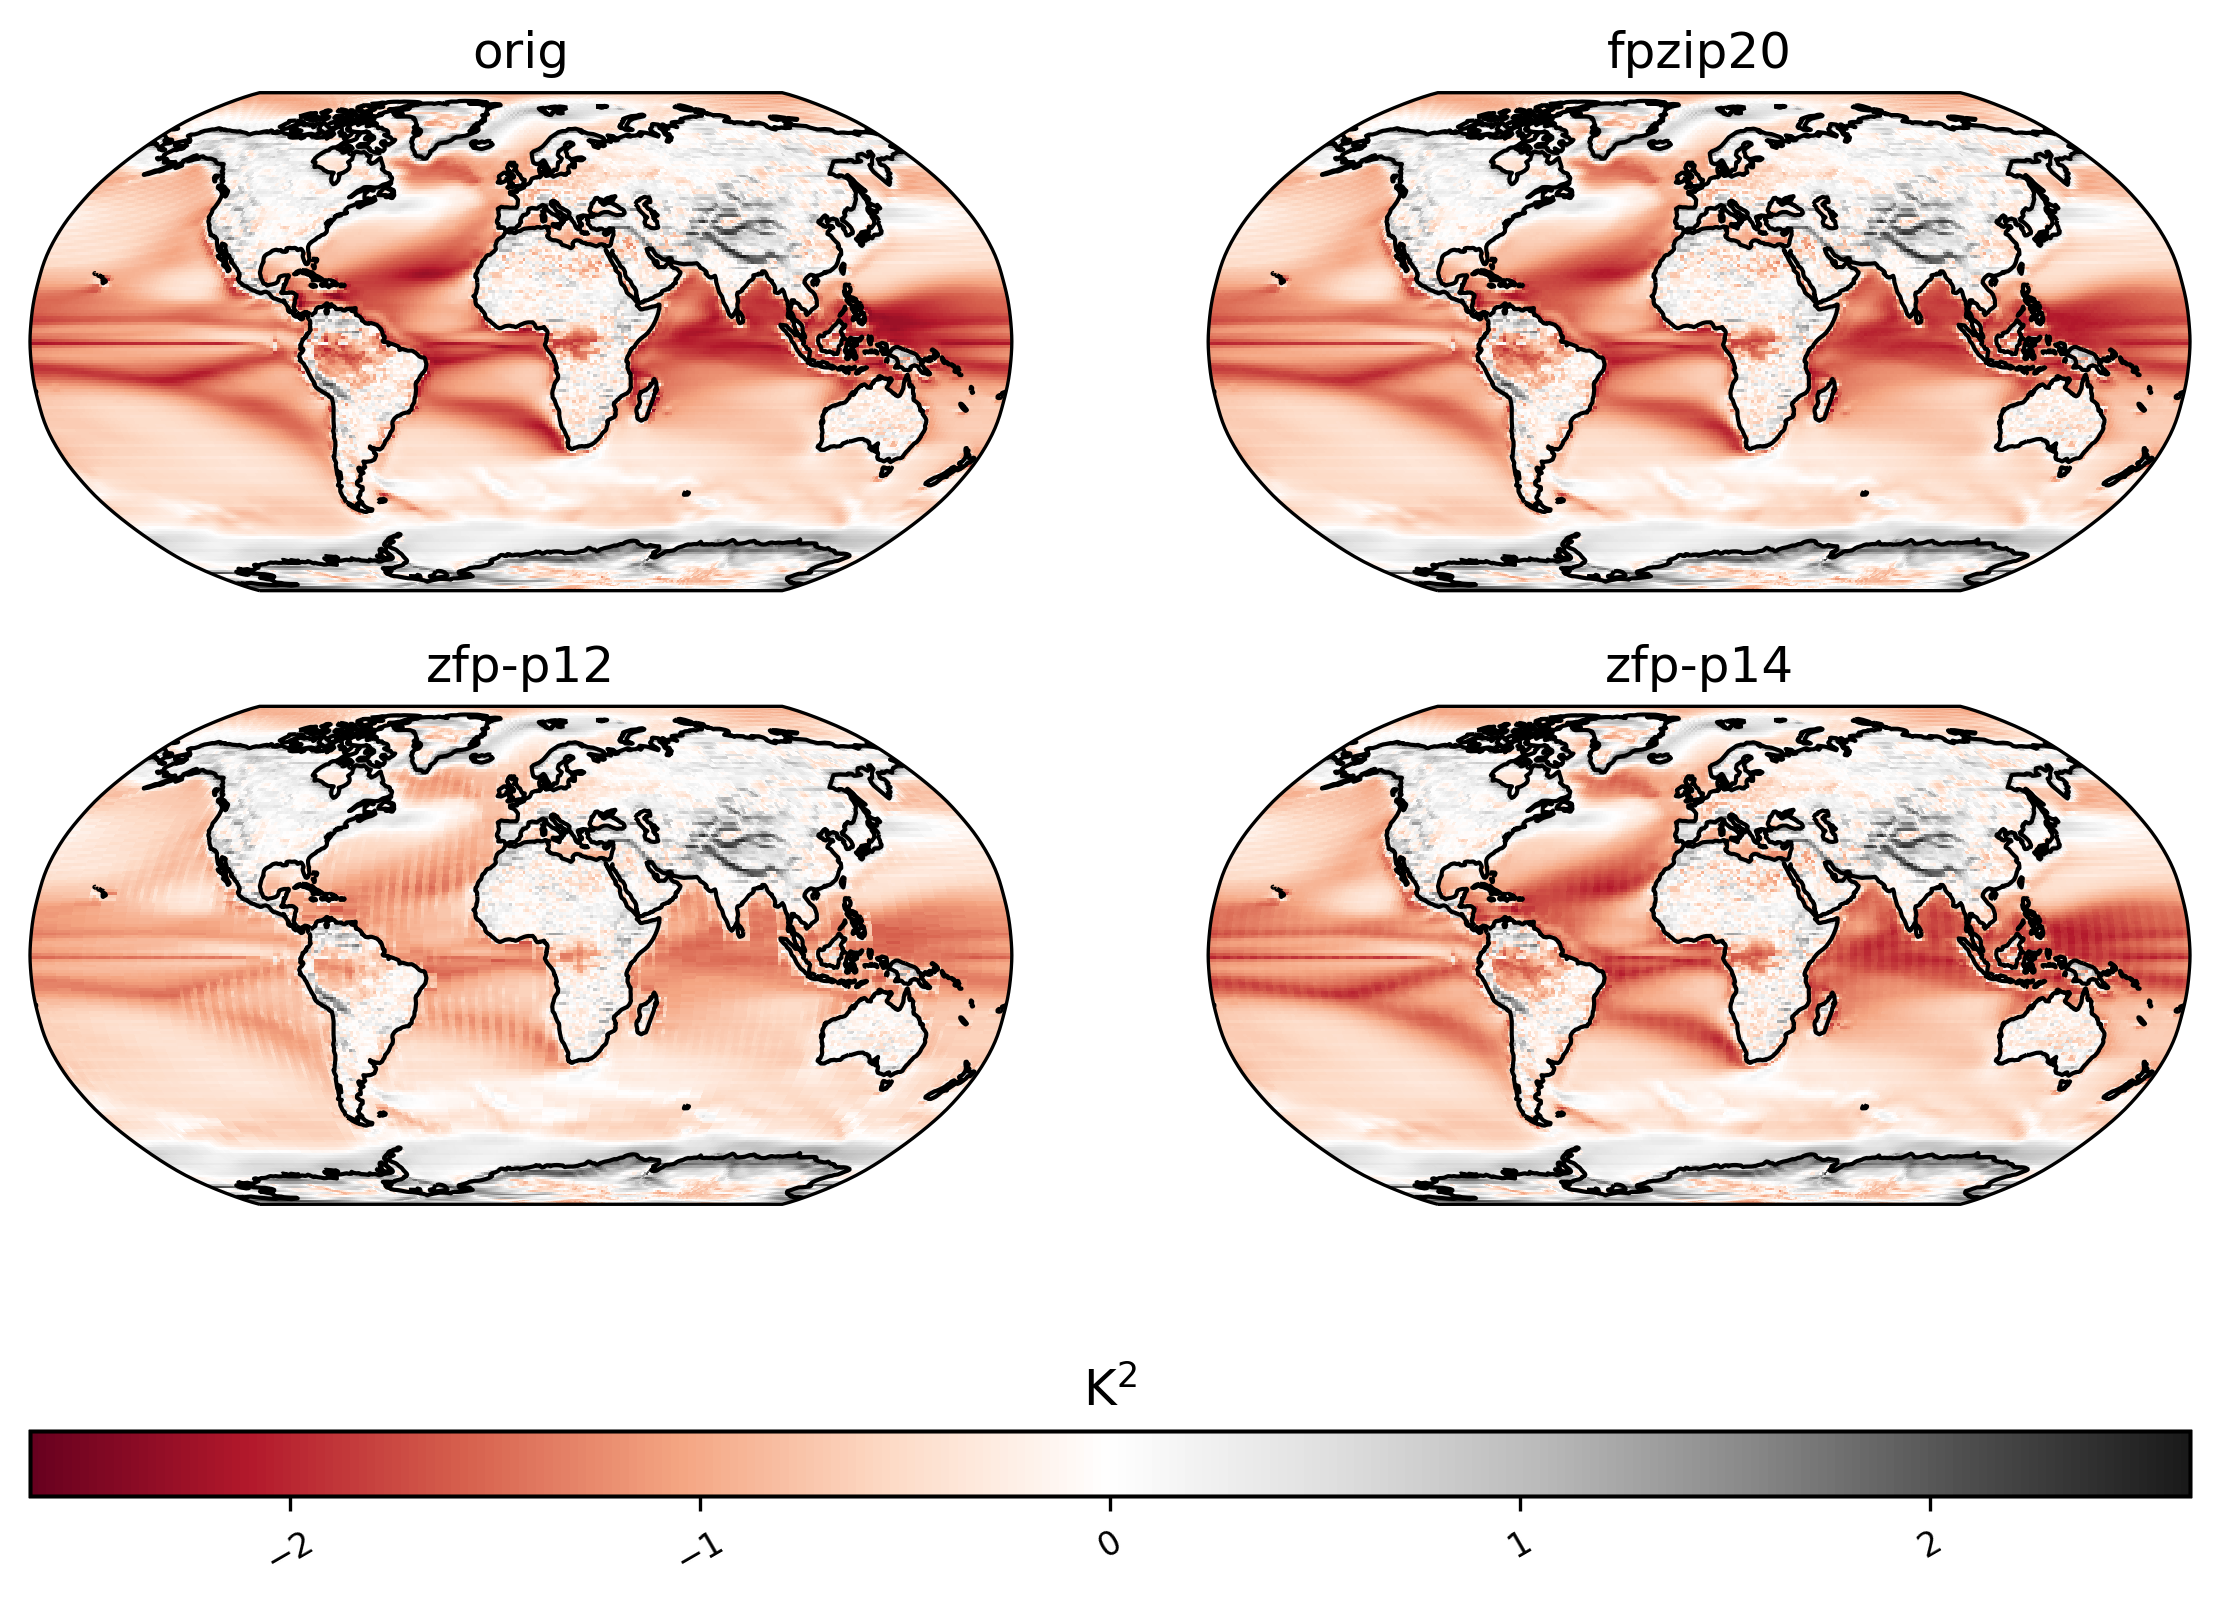

In [20]:
# Let's look and compare the north south contrast variances
ldcpy.plot(
    col_trefht,
    "TREFHT",
    sets=["orig", "fpzip20", "zfp-p12", "zfp-p14"],
    calc="ns_con_var",
    color="RdGy",
    calc_type="raw",
    transform="log",
    axes_symmetric=True,
    short_title=True,
)

In [21]:
# List the compressed data files for LHFLX
os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX")

['zfp.p14.LHFLX.daily.19200101-20051231.nc',
 'zfp.p12.LHFLX.daily.19200101-20051231.nc',
 'zfp.p18.LHFLX.daily.20060101-20801231.nc',
 'zfp.p12.LHFLX.daily.20060101-20801231.nc',
 'zfp.p16.LHFLX.daily.20060101-20801231.nc',
 'zfp.p22.LHFLX.daily.20060101-20801231.nc',
 'fpzip16.LHFLX.daily.19200101-20051231.nc',
 'zfp.p10.LHFLX.daily.19200101-20051231.nc',
 'fpzip16.LHFLX.daily.20060101-20801231.nc',
 'zfp.p8.LHFLX.daily.19200101-20051231.nc',
 'zfp.p8.LHFLX.daily.20060101-20801231.nc',
 'zfp.p20.LHFLX.daily.20060101-20801231.nc',
 'zfp.p14.LHFLX.daily.20060101-20801231.nc',
 'zfp.p10.LHFLX.daily.20060101-20801231.nc',
 'zfp.p16.LHFLX.daily.19200101-20051231.nc',
 'zfp.p22.LHFLX.daily.19200101-20051231.nc',
 'zfp.p18.LHFLX.daily.19200101-20051231.nc',
 'zfp.p20.LHFLX.daily.19200101-20051231.nc']

In [22]:
col_lhflx = ldcpy.open_datasets(
    ["LHFLX"],
    [
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/orig/LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/fpzip16.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p8.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p10.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p12.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p14.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p16.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p18.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p20.LHFLX.daily.20060101-20801231.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/LHFLX/zfp.p22.LHFLX.daily.20060101-20801231.nc",
    ],
    [
        "orig",
        "fpzip16",
        "zfp-p8",
        "zfp-p10",
        "zfp-p12",
        "zfp-p14",
        "zfp-p16",
        "zfp-p18",
        "zfp-p20",
        "zfp-p22",
    ],
    chunks={"time": 100},
)
col_lhflx

dataset size in GB 60.55



<xarray.Dataset>
Dimensions:     (collection: 10, lat: 192, lon: 288, time: 27375)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 2006-01-01 00:00:00 ... 2080-12-31 00:00:00
  * collection  (collection) <U7 'orig' 'fpzip16' ... 'zfp-p20' 'zfp-p22'
Data variables:
    LHFLX       (collection, time, lat, lon) float32 dask.array<chunksize=(1, 100, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.BRCP85C5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys1023
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.031.cam.i.2006-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Wed Nov 11 19:15:10 2020: ncks -L 5 LHFLX.daily.2006010...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

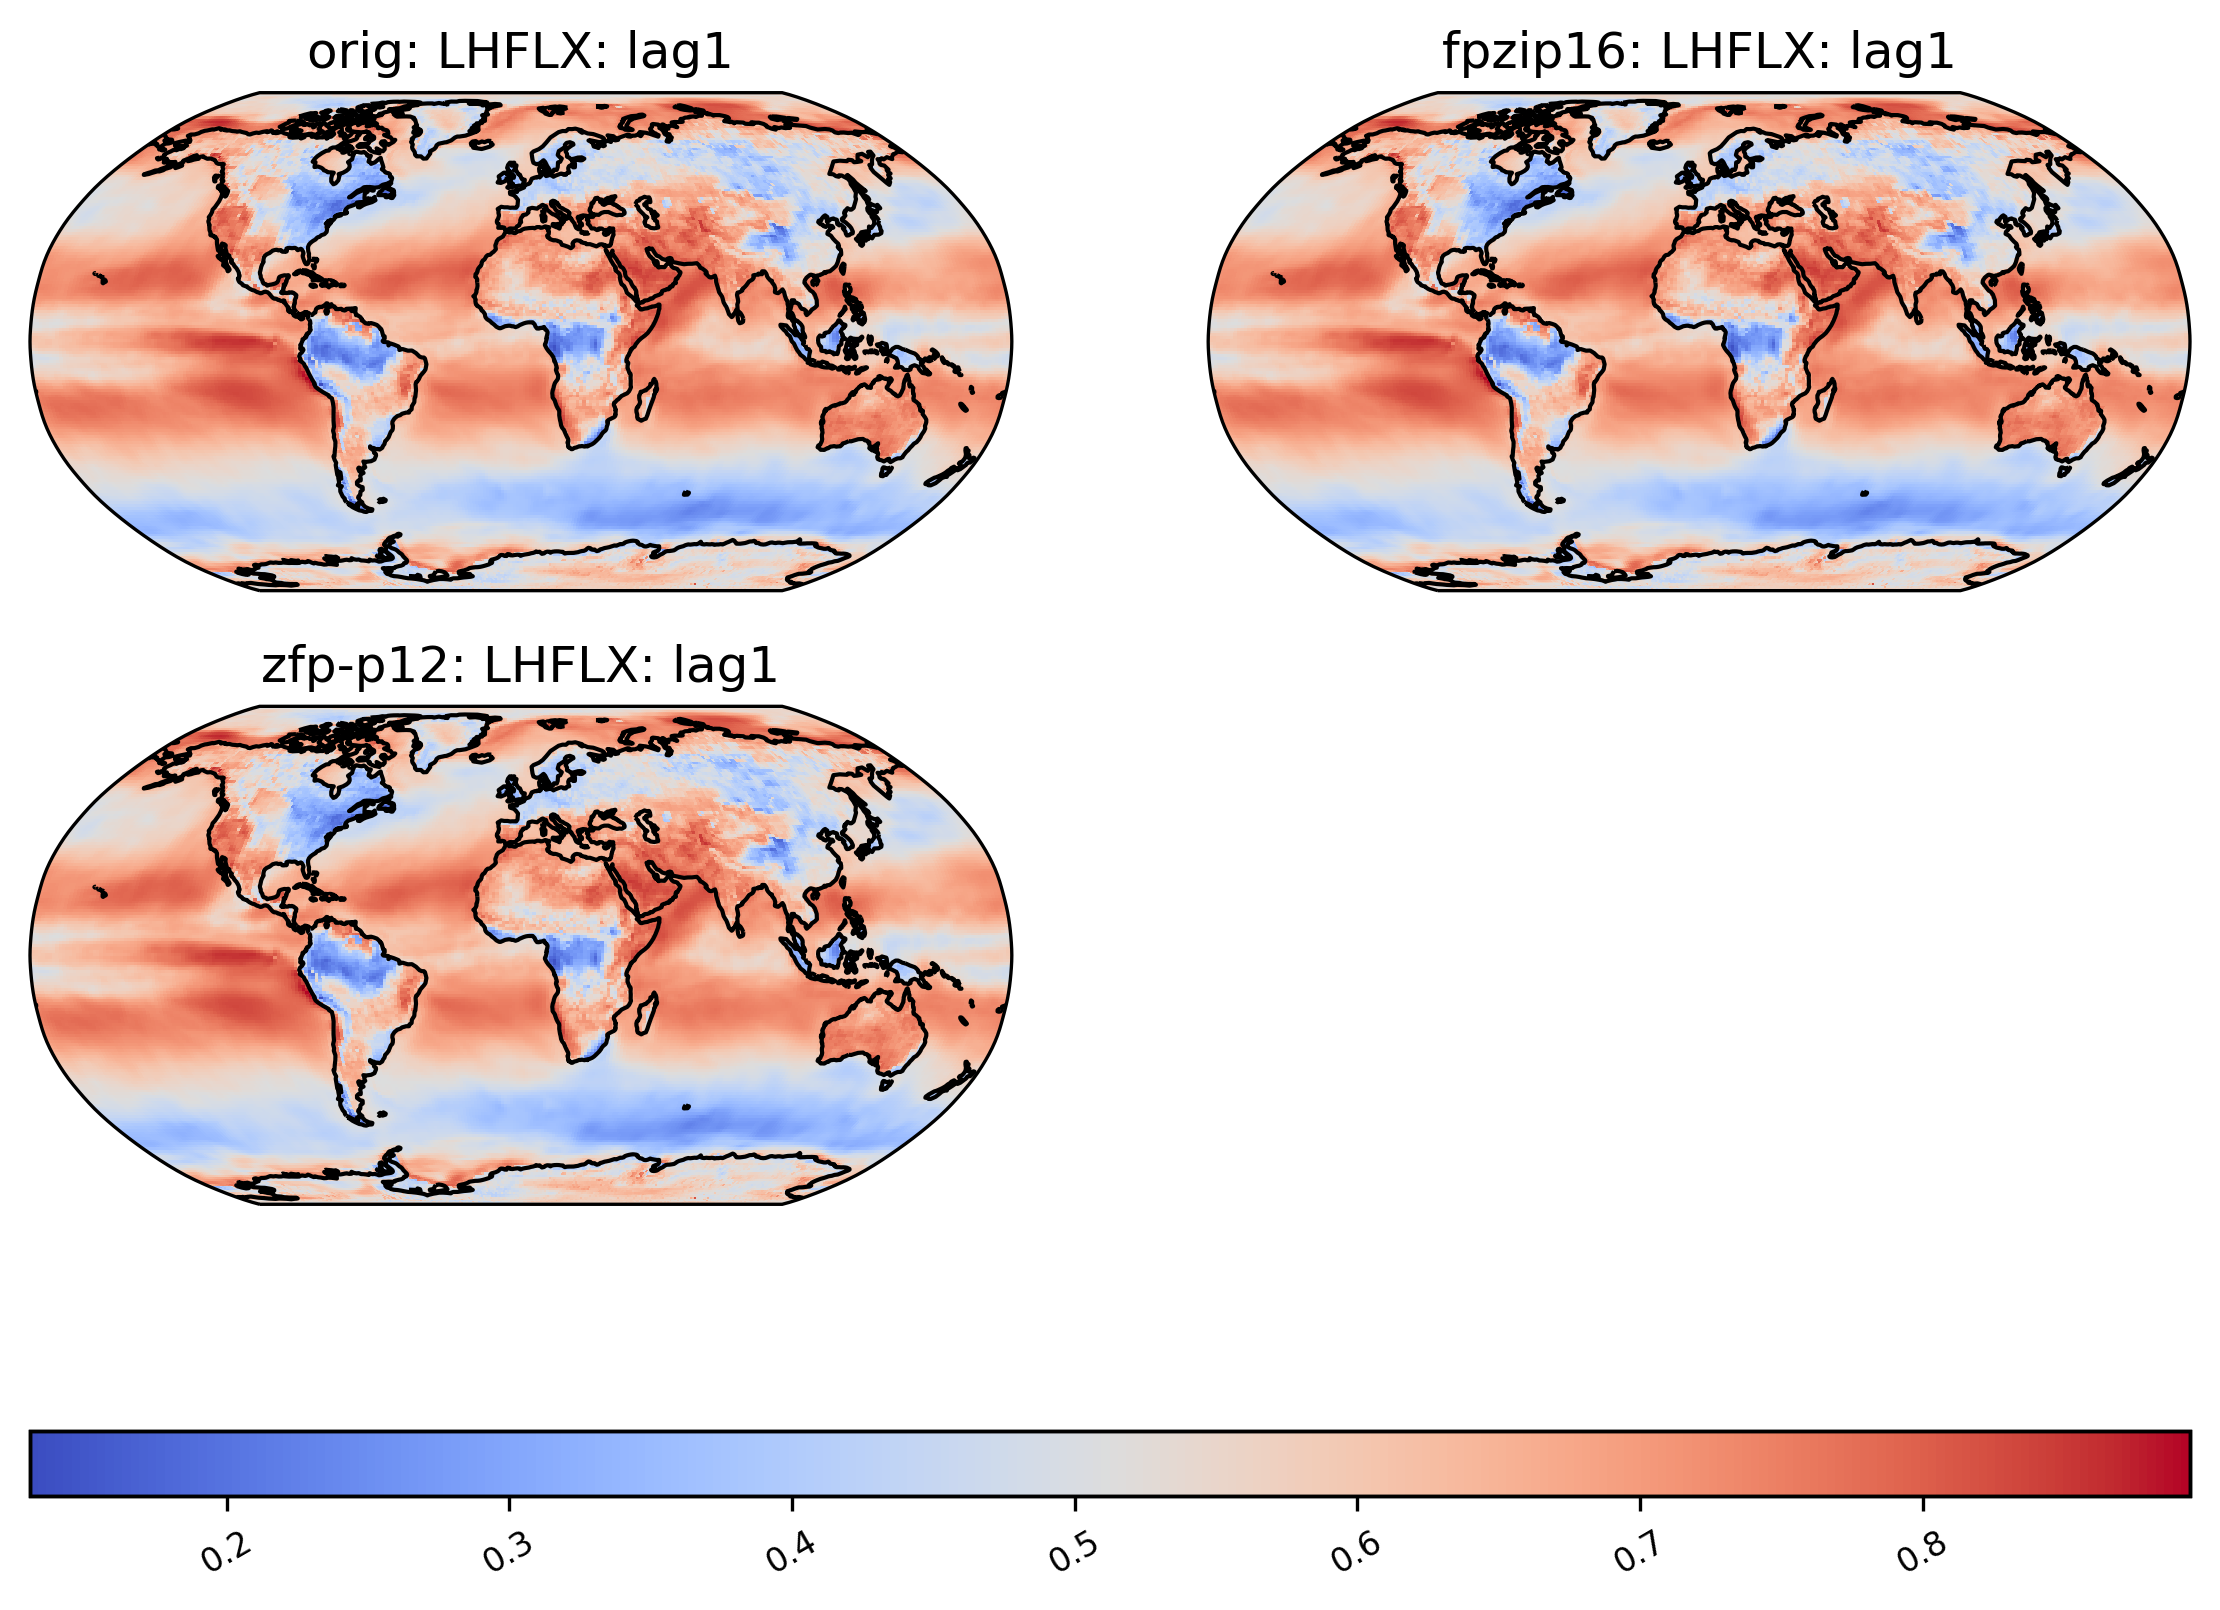

In [26]:
# plot of lag-1 correlation of LHFLX values for the first 10 years (NOTE: daily data takes longer)
ldcpy.plot(
    col_lhflx,
    "LHFLX",
    sets=["orig", "fpzip16", "zfp-p12"],
    calc="lag1",
    start=0,
    end=3650,
)

In [27]:
# List the compressed data files for Q
os.listdir("/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q")

['zfp.p18.Q.monthly.192001-200512.nc',
 'zfp.p10.Q.monthly.200601-208012.nc',
 'zfp.p16.Q.monthly.200601-208012.nc',
 'zfp.p20.Q.monthly.200601-208012.nc',
 'zfp.p8.Q.monthly.200601-208012.nc',
 'zfp.p10.Q.monthly.192001-200512.nc',
 'zfp.p22.Q.monthly.200601-208012.nc',
 'fpzip20.Q.monthly.192001-200512.nc',
 'fpzip20.Q.monthly.200601-208012.nc',
 'zfp.p18.Q.monthly.200601-208012.nc',
 'zfp.p12.Q.monthly.200601-208012.nc',
 'zfp.p20.Q.monthly.192001-200512.nc',
 'zfp.p22.Q.monthly.192001-200512.nc',
 'zfp.p14.Q.monthly.200601-208012.nc',
 'zfp.p8.Q.monthly.192001-200512.nc',
 'zfp.p14.Q.monthly.192001-200512.nc',
 'zfp.p12.Q.monthly.192001-200512.nc',
 'zfp.p16.Q.monthly.192001-200512.nc']

In [28]:
col_q = ldcpy.open_datasets(
    ["Q"],
    [
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/orig/Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/fpzip20.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p8.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p10.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p12.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p14.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p16.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p18.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p20.Q.monthly.200601-208012.nc",
        "/glade/p/cisl/asap/abaker/compression_samples/cam-lens/Q/zfp.p22.Q.monthly.200601-208012.nc",
    ],
    [
        "orig",
        "fpzip20",
        "zfp-p8",
        "zfp-p10",
        "zfp-p12",
        "zfp-p14",
        "zfp-p16",
        "zfp-p18",
        "zfp-p20",
        "zfp-p22",
    ],
    chunks={"time": 100},
)
col_q

dataset size in GB 59.72



<xarray.Dataset>
Dimensions:     (collection: 10, lat: 192, lev: 30, lon: 288, time: 900)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev         (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 2006-02-01 00:00:00 ... 2081-01-01 00:00:00
  * collection  (collection) <U7 'orig' 'fpzip20' ... 'zfp-p20' 'zfp-p22'
Data variables:
    Q           (collection, time, lev, lat, lon) float32 dask.array<chunksize=(1, 100, 30, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.BRCP85C5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys1023
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.031.cam.i.2006-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Wed Nov 11 17:21:59 2020: ncks -L 5 Q.monthly.200601-20...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

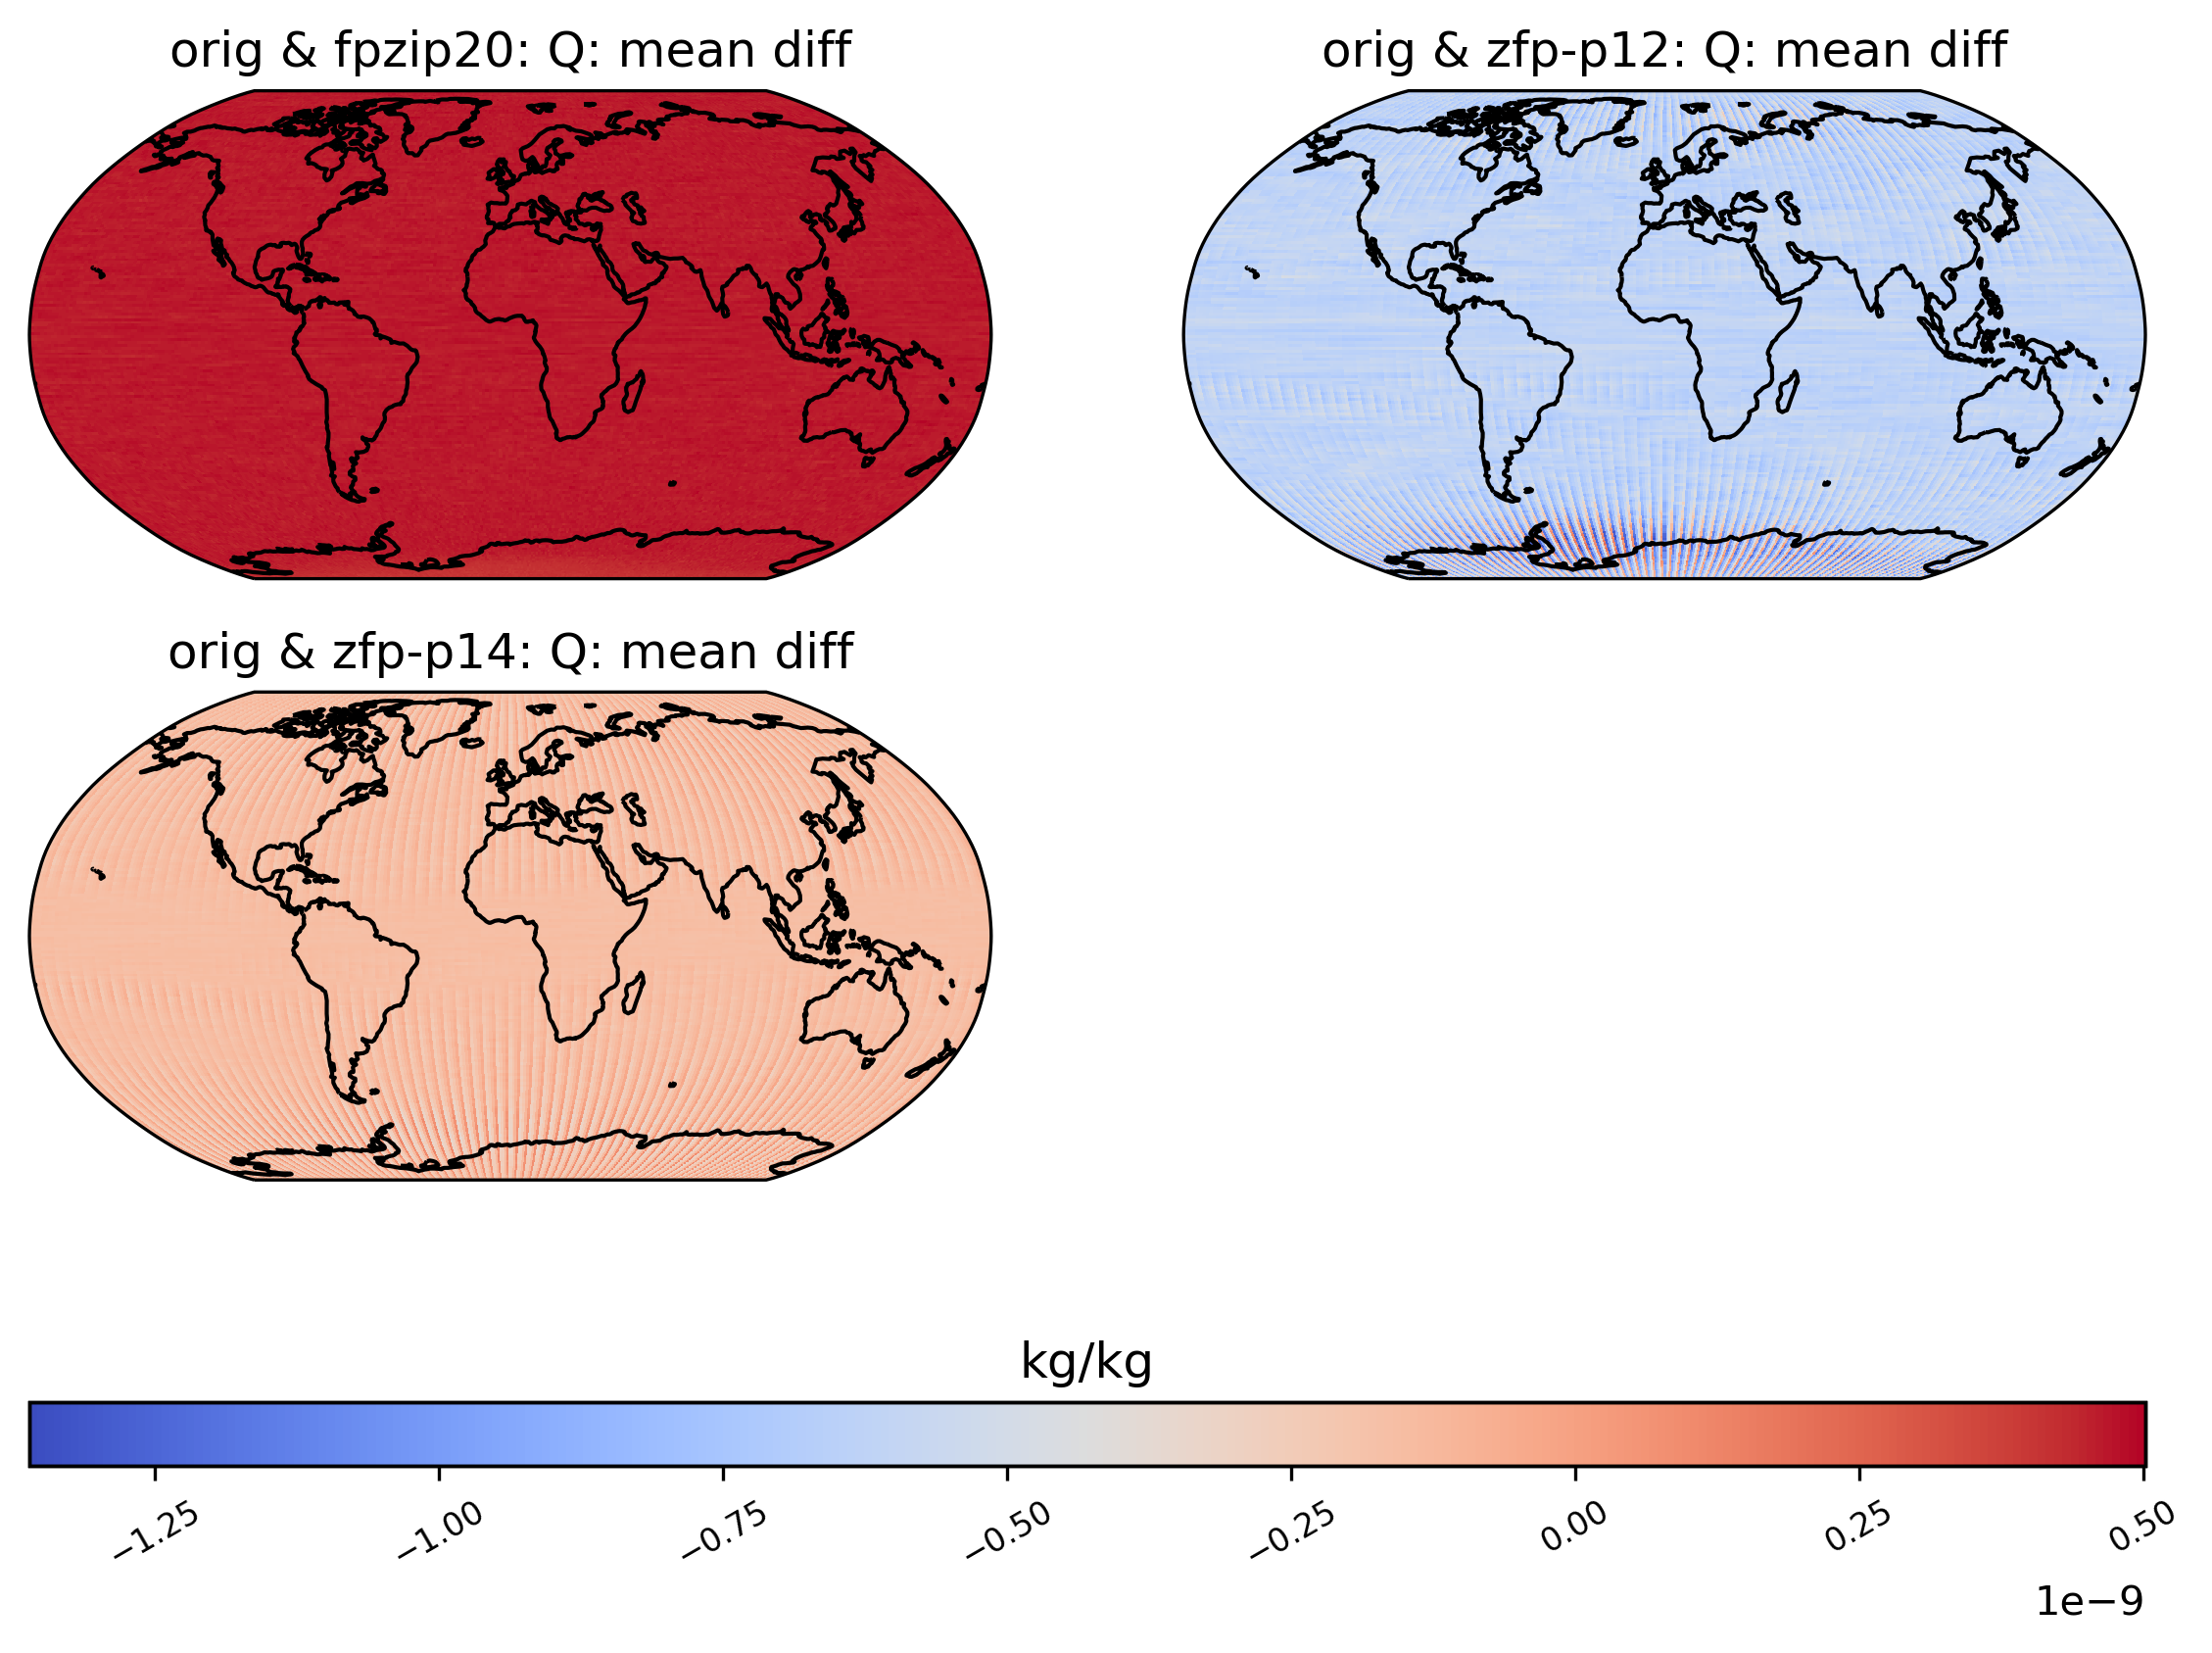

In [29]:
# diff between mean Q values across the entire timeseries
ldcpy.plot(
    col_q, "Q", sets=["orig", "fpzip20", "zfp-p12", "zfp-p14"], calc="mean", calc_type="diff", lev=0
)

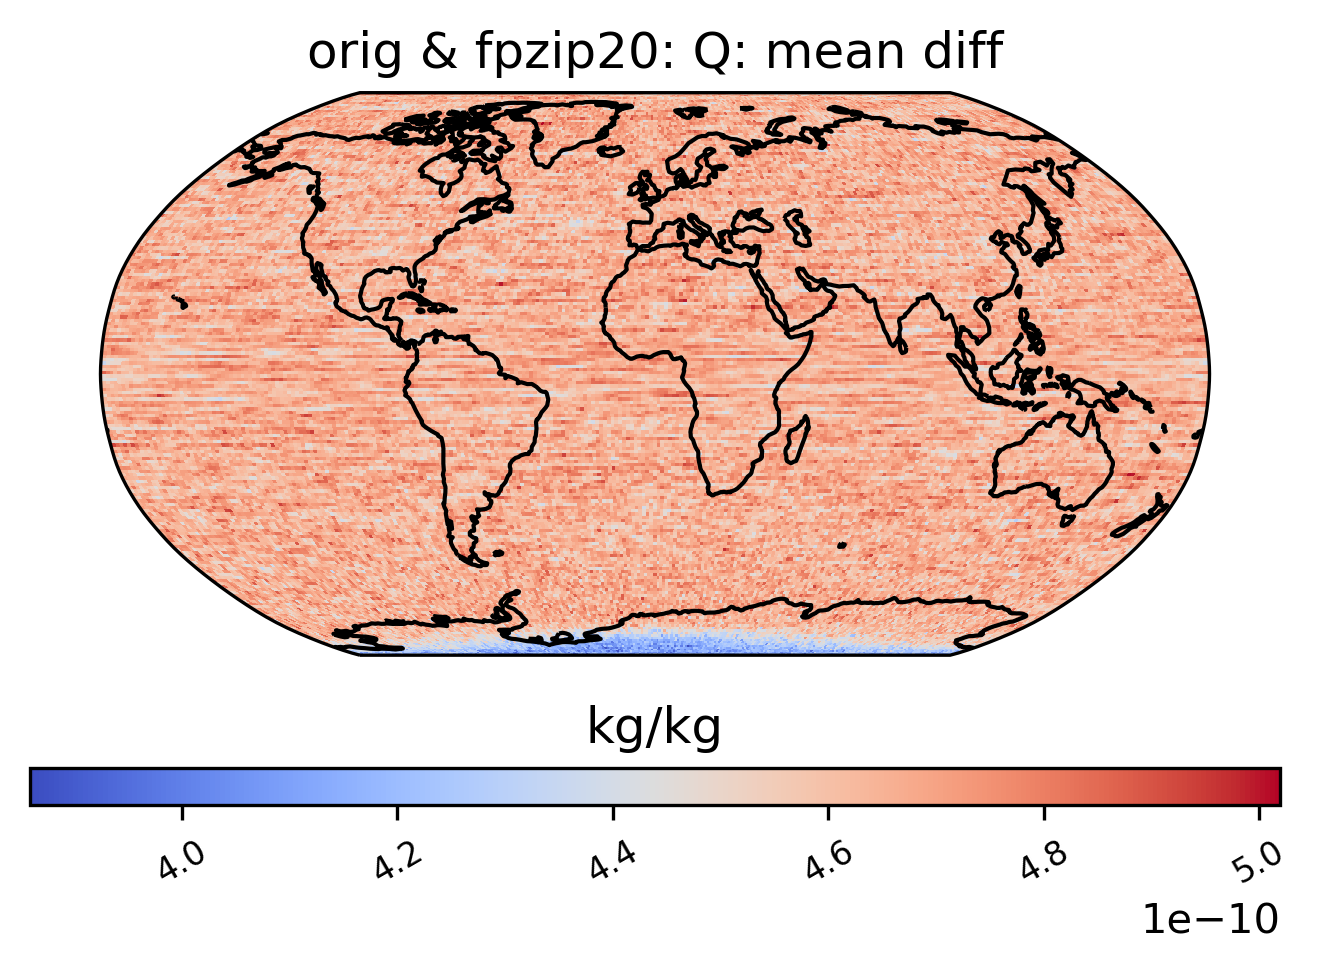

In [30]:
# diff between mean Q values across the entire timeseries - look at just one from above
ldcpy.plot(col_q, "Q", sets=["orig", "fpzip20"], calc="mean", calc_type="diff", lev=0)

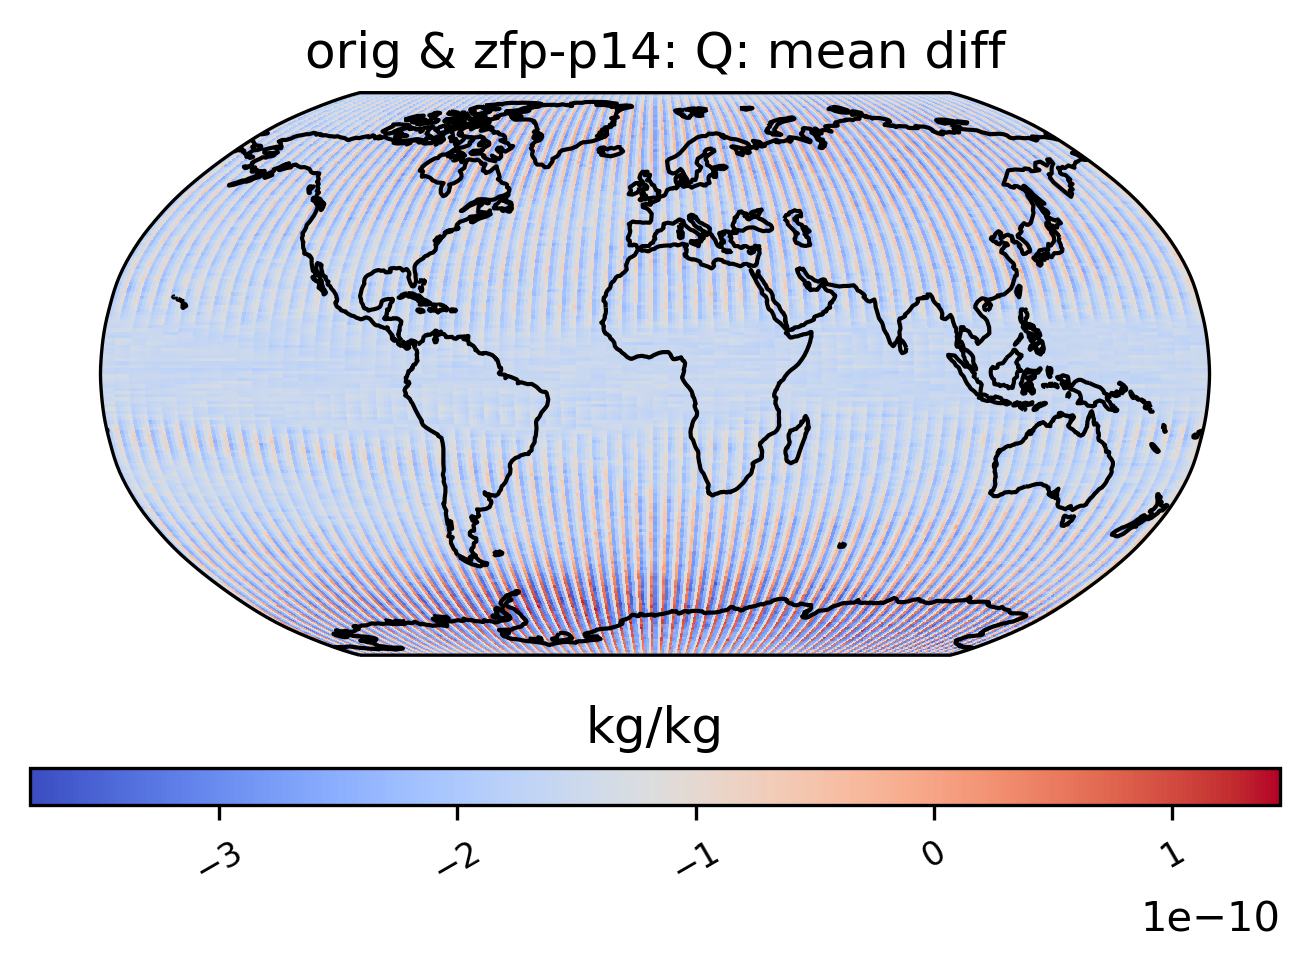

In [31]:
# diff between mean Q values across the entire timeseries - look at just one from above
ldcpy.plot(col_q, "Q", sets=["orig", "zfp-p14"], calc="mean", calc_type="diff", lev=0)

 
mean orig                          : 2.2156e-06
mean fpzip20                       : 2.2151e-06
mean diff                          : 4.6242e-10
 
variance orig                      : 9.5578e-15
variance fpzip20                   : 9.5584e-15
 
standard deviation orig            : 9.7765e-08
standard deviation fpzip20         : 9.7768e-08
 
max value orig                     : 3.2387e-06
max value fpzip20                  : 3.2382e-06
min value orig                     : 2.1375e-06
min value fpzip20                  : 2.1374e-06
 
max abs diff                       : 9.311e-10
min abs diff                       : 0
mean abs diff                      : 4.6242e-10
mean squared diff                  : 2.1383e-19
root mean squared diff             : 5.351e-10
normalized root mean squared diff  : 0.0004859
normalized max pointwise error     : 0.00084549
pearson correlation coefficient    : 1
ks p-value                         : 6.4126e-18
spatial relative error(% > 0.0001) : 75.96
max spat

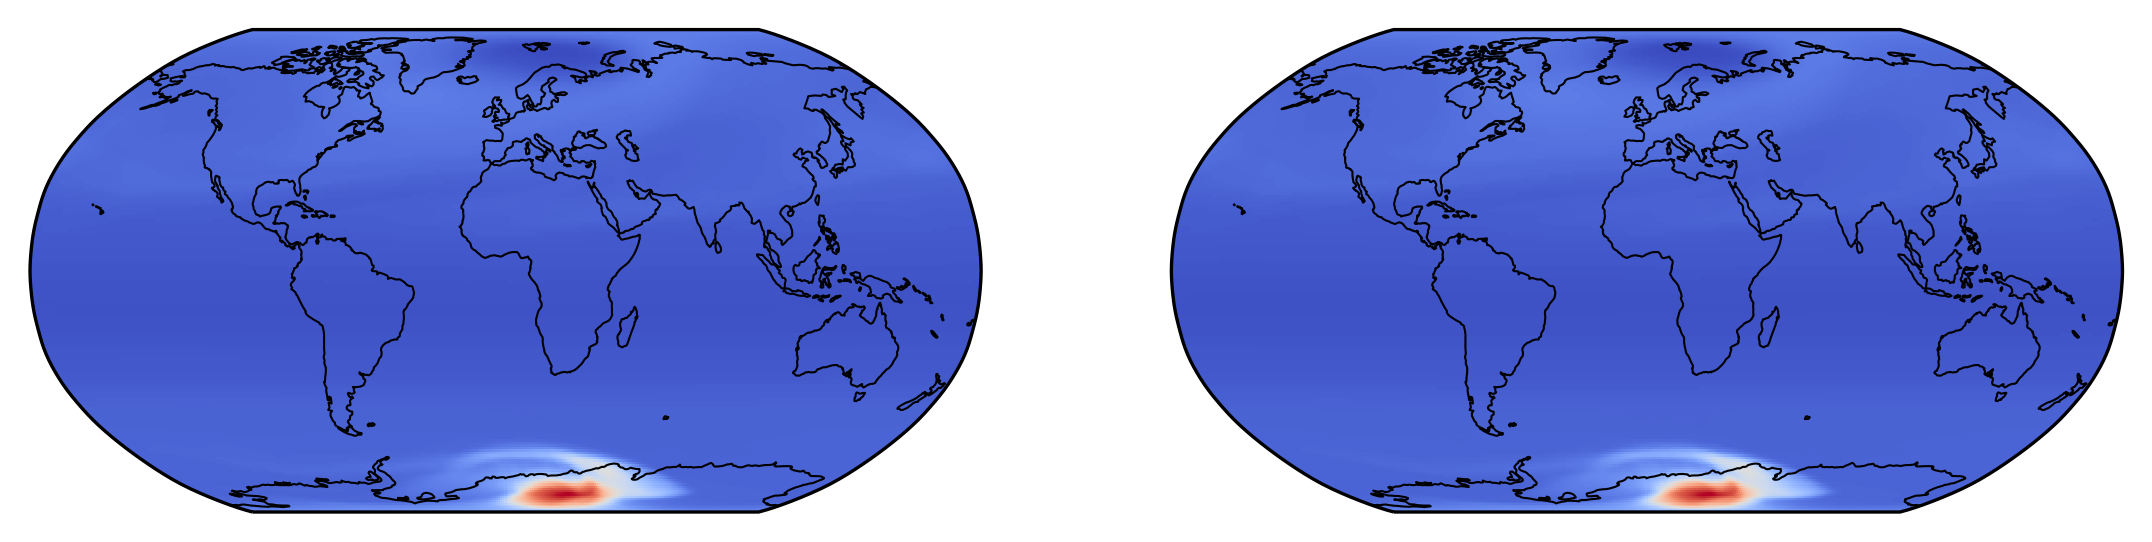

In [35]:
# Note: since q is 3D, need to select a level and a time slice
ldcpy.compare_stats(col_q.isel(time=0, lev=0), "Q", "orig", "fpzip20")

In [36]:
# Disconnect when finished
cluster.close()
client.close()